In [1]:
"""
A simple example of the Stiefel landing algorithm on PCA problem
"""
from time import time

import matplotlib.pyplot as plt

import numpy as np
import cupy as cp

from solvers import GeneralizedLanding
from solvers import RiemmGeneralizedStiefel
from experiments import generate_spd

from scipy.linalg import eigh
import scipy

/opt/mambaforge/envs/landing/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Solve the following:
$$
\min_{X\in\mathbb{R}^{n\times p}} -\frac12 \mathrm{Tr}(X^\top A X ) \qquad \mathrm{s.t.}\qquad X^\top B X = I_p
$$

In [5]:
n = 1000
p = 500

cond_number = 1e2

_,_,A = generate_spd(n, cond_number= cond_number)
_,_,B = generate_spd(n, type = 'exponential', cond_number= cond_number)

A = A / np.linalg.norm(A)
B = B / np.linalg.norm(B)

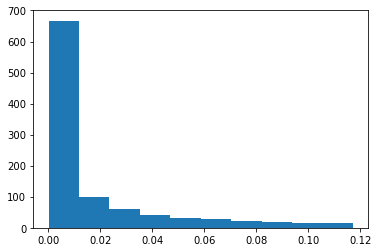

0.00020638846148434323
0.024410040131027176


In [6]:
etmp,_ = np.linalg.eig(B)
plt.hist(etmp)
plt.show()
print(etmp[-1])
etmp,_ = np.linalg.eig(A)
print(etmp[-1])

In [7]:
# Compute true solution
uB, sB, vB = np.linalg.svd(B)
B_sqrt_inv = np.dot(uB * sB**(-0.5), uB.T)
M = B_sqrt_inv @ A @ B_sqrt_inv
uG, sG, vhG = np.linalg.svd(M)
x_true = B_sqrt_inv  @ uG[:,:p]

In [8]:
np.trace(x_true.T @ A @ x_true)

33071.84055434476

In [9]:
[n-p, n-1]

[500, 999]

In [10]:
eigvals, eigvecs = eigh(A, B, eigvals_only=False, subset_by_index=[n-p, n-1])

In [11]:
obj_true = -0.5*np.trace(eigvecs.T @ A @ eigvecs)
print(obj_true)

-16535.92027717235


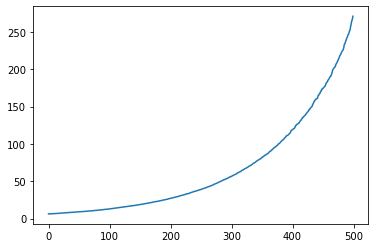

In [12]:
plt.plot(np.diag(eigvecs.T @ A @ eigvecs))

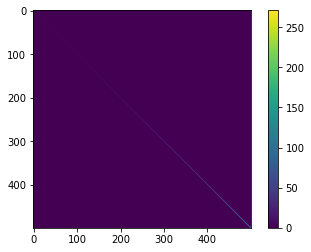

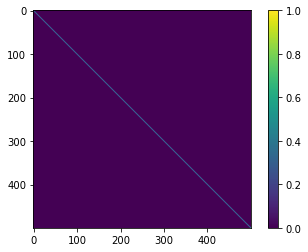

In [13]:
plt.imshow(eigvecs.T @ A @ eigvecs)
plt.colorbar()
plt.show()
plt.imshow(eigvecs.T @ B @ eigvecs)
plt.colorbar()
plt.show()

In [1]:
x0,_ = np.linalg.qr(np.random.randn(n,p))
Bsqrt = scipy.linalg.sqrtm(B)
x0 = (np.linalg.inv(Bsqrt) @ x0).real #+ .1*np.random.randn(n,p)

NameError: name 'np' is not defined

In [33]:
solver = RiemmGeneralizedStiefel(A, B, p, maxiter = 150, mingradnorm=1e-6,maxtime=60)
x_rsd, optlog_rsd = solver.solve(eta = .001, step_type = 'fixed', x0=x0)

Iteration 1, Objective: -9244.48 Distance: 8.93e-26 gradnorm: 4.94e+04
Iteration 2, Objective: -10006.12 Distance: 1.04e-25 gradnorm: 4.60e+04
Iteration 3, Objective: -10711.06 Distance: 1.17e-25 gradnorm: 4.17e+04
Iteration 4, Objective: -11341.24 Distance: 1.29e-25 gradnorm: 3.69e+04
Iteration 5, Objective: -11890.10 Distance: 1.41e-25 gradnorm: 3.23e+04
Iteration 6, Objective: -12360.17 Distance: 1.50e-25 gradnorm: 2.82e+04
Iteration 7, Objective: -12759.31 Distance: 1.60e-25 gradnorm: 2.46e+04
Iteration 8, Objective: -13097.52 Distance: 1.67e-25 gradnorm: 2.15e+04
Iteration 9, Objective: -13384.81 Distance: 1.75e-25 gradnorm: 1.90e+04
Iteration 10, Objective: -13630.14 Distance: 1.80e-25 gradnorm: 1.69e+04
Iteration 11, Objective: -13841.11 Distance: 1.87e-25 gradnorm: 1.51e+04
Iteration 12, Objective: -14023.93 Distance: 1.91e-25 gradnorm: 1.36e+04
Iteration 13, Objective: -14183.60 Distance: 1.95e-25 gradnorm: 1.24e+04
Iteration 14, Objective: -14324.10 Distance: 1.99e-25 gradnor

In [31]:
solver = GeneralizedLanding(A, B, p, maxiter = 400, mingradnorm=1e-6,maxtime=60)
x_landing, optlog_landing = solver.solve(.001, 1, grad_type='riem', x0=x0, step_type='fixed')

Iteration 1, Objective: -9287.70 Distance: 1.42e-03
Iteration 2, Objective: -10088.72 Distance: 4.19e-03
Iteration 3, Objective: -10822.77 Distance: 6.49e-03
Iteration 4, Objective: -11468.93 Distance: 7.58e-03
Iteration 5, Objective: -12021.75 Distance: 7.58e-03
Iteration 6, Objective: -12487.15 Distance: 6.96e-03
Iteration 7, Objective: -12876.72 Distance: 6.12e-03
Iteration 8, Objective: -13203.31 Distance: 5.28e-03
Iteration 9, Objective: -13478.76 Distance: 4.52e-03
Iteration 10, Objective: -13713.02 Distance: 3.89e-03
Iteration 11, Objective: -13914.10 Distance: 3.36e-03
Iteration 12, Objective: -14088.31 Distance: 2.93e-03
Iteration 13, Objective: -14240.57 Distance: 2.57e-03
Iteration 14, Objective: -14374.76 Distance: 2.27e-03
Iteration 15, Objective: -14493.90 Distance: 2.02e-03
Iteration 16, Objective: -14600.40 Distance: 1.81e-03
Iteration 17, Objective: -14696.19 Distance: 1.63e-03
Iteration 18, Objective: -14782.83 Distance: 1.47e-03
Iteration 19, Objective: -14861.60 Dis

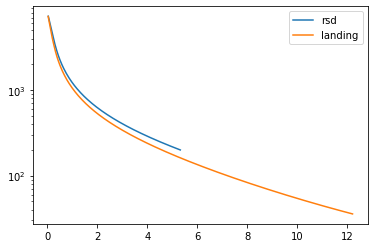

In [34]:
plt.semilogy(optlog_rsd['iterations']['time'], optlog_rsd['iterations']['fx'] - obj_true, label = 'rsd')
plt.semilogy(optlog_landing['iterations']['time'], optlog_landing['iterations']['fx'] - obj_true, label='landing')
plt.legend()
plt.show()

In [14]:
optlog['iterations']['gradnorm']

[612.8559459201923,
 563.7044739516385,
 433.05937514281743,
 287.9589485925422,
 224.06925405560503,
 195.9228777769159,
 153.18257990985137,
 97.59540979998792,
 65.69518285583243,
 49.43415826449253,
 44.44430546978716,
 38.22538804078097,
 39.07781657610271,
 27.522691207653278,
 26.241807016582378,
 24.27250265812933,
 21.033389626256586,
 36.19570478333994,
 34.84805911421824,
 33.97555730109951,
 23.26988033094669,
 17.821806395489904,
 13.837057937976882,
 13.289597466473689,
 12.761963252145607,
 19.042102758217837,
 11.647834934529188,
 10.659274193336971,
 10.393187448916793,
 13.095199865062066,
 9.302442637315195,
 9.16353017138766,
 8.921391069618476,
 8.456898708728827,
 7.661128249283997,
 17.25487675970808,
 12.25224450127127,
 9.269911826502533,
 6.4383427552625845,
 6.023335378266698,
 5.981016147647173,
 8.372006803029334,
 5.477725906587427,
 5.3884580556589174,
 5.275358726650773,
 5.055782654984853,
 4.954620458597938,
 30.035234177472738,
 19.756145655966275,
 1

In [15]:
optlog['iterations']['fx']

[-69.92307267112751,
 -184.0078637380729,
 -302.972672042547,
 -320.4211205876361,
 -332.72911325183185,
 -350.6919749643289,
 -369.7125420247445,
 -380.741926504783,
 -381.9650047754408,
 -382.77892375086026,
 -384.0175620375886,
 -385.5807402415419,
 -385.83084872019657,
 -386.0189510453124,
 -386.3574155669243,
 -386.90823425652343,
 -387.57861738011013,
 -387.67582627074296,
 -387.76355139839956,
 -387.81417286573037,
 -387.84240199309437,
 -387.87992696251274,
 -387.9390338914699,
 -388.0474416896655,
 -388.21954708556297,
 -388.2626888065888,
 -388.2928985850255,
 -388.3482687625533,
 -388.44418652920154,
 -388.46632476509654,
 -388.4834972159547,
 -388.5166265788621,
 -388.578371216228,
 -388.68547172529236,
 -388.8328377590478,
 -388.8429766339067,
 -388.84868589575024,
 -388.8556327657594,
 -388.8649519581825,
 -388.88248714863994,
 -388.91341399535787,
 -388.9215391478351,
 -388.927474950915,
 -388.9390041674268,
 -388.96086643622954,
 -388.999880928784,
 -389.015347952439,
 

NameError: name 'optlog4' is not defined

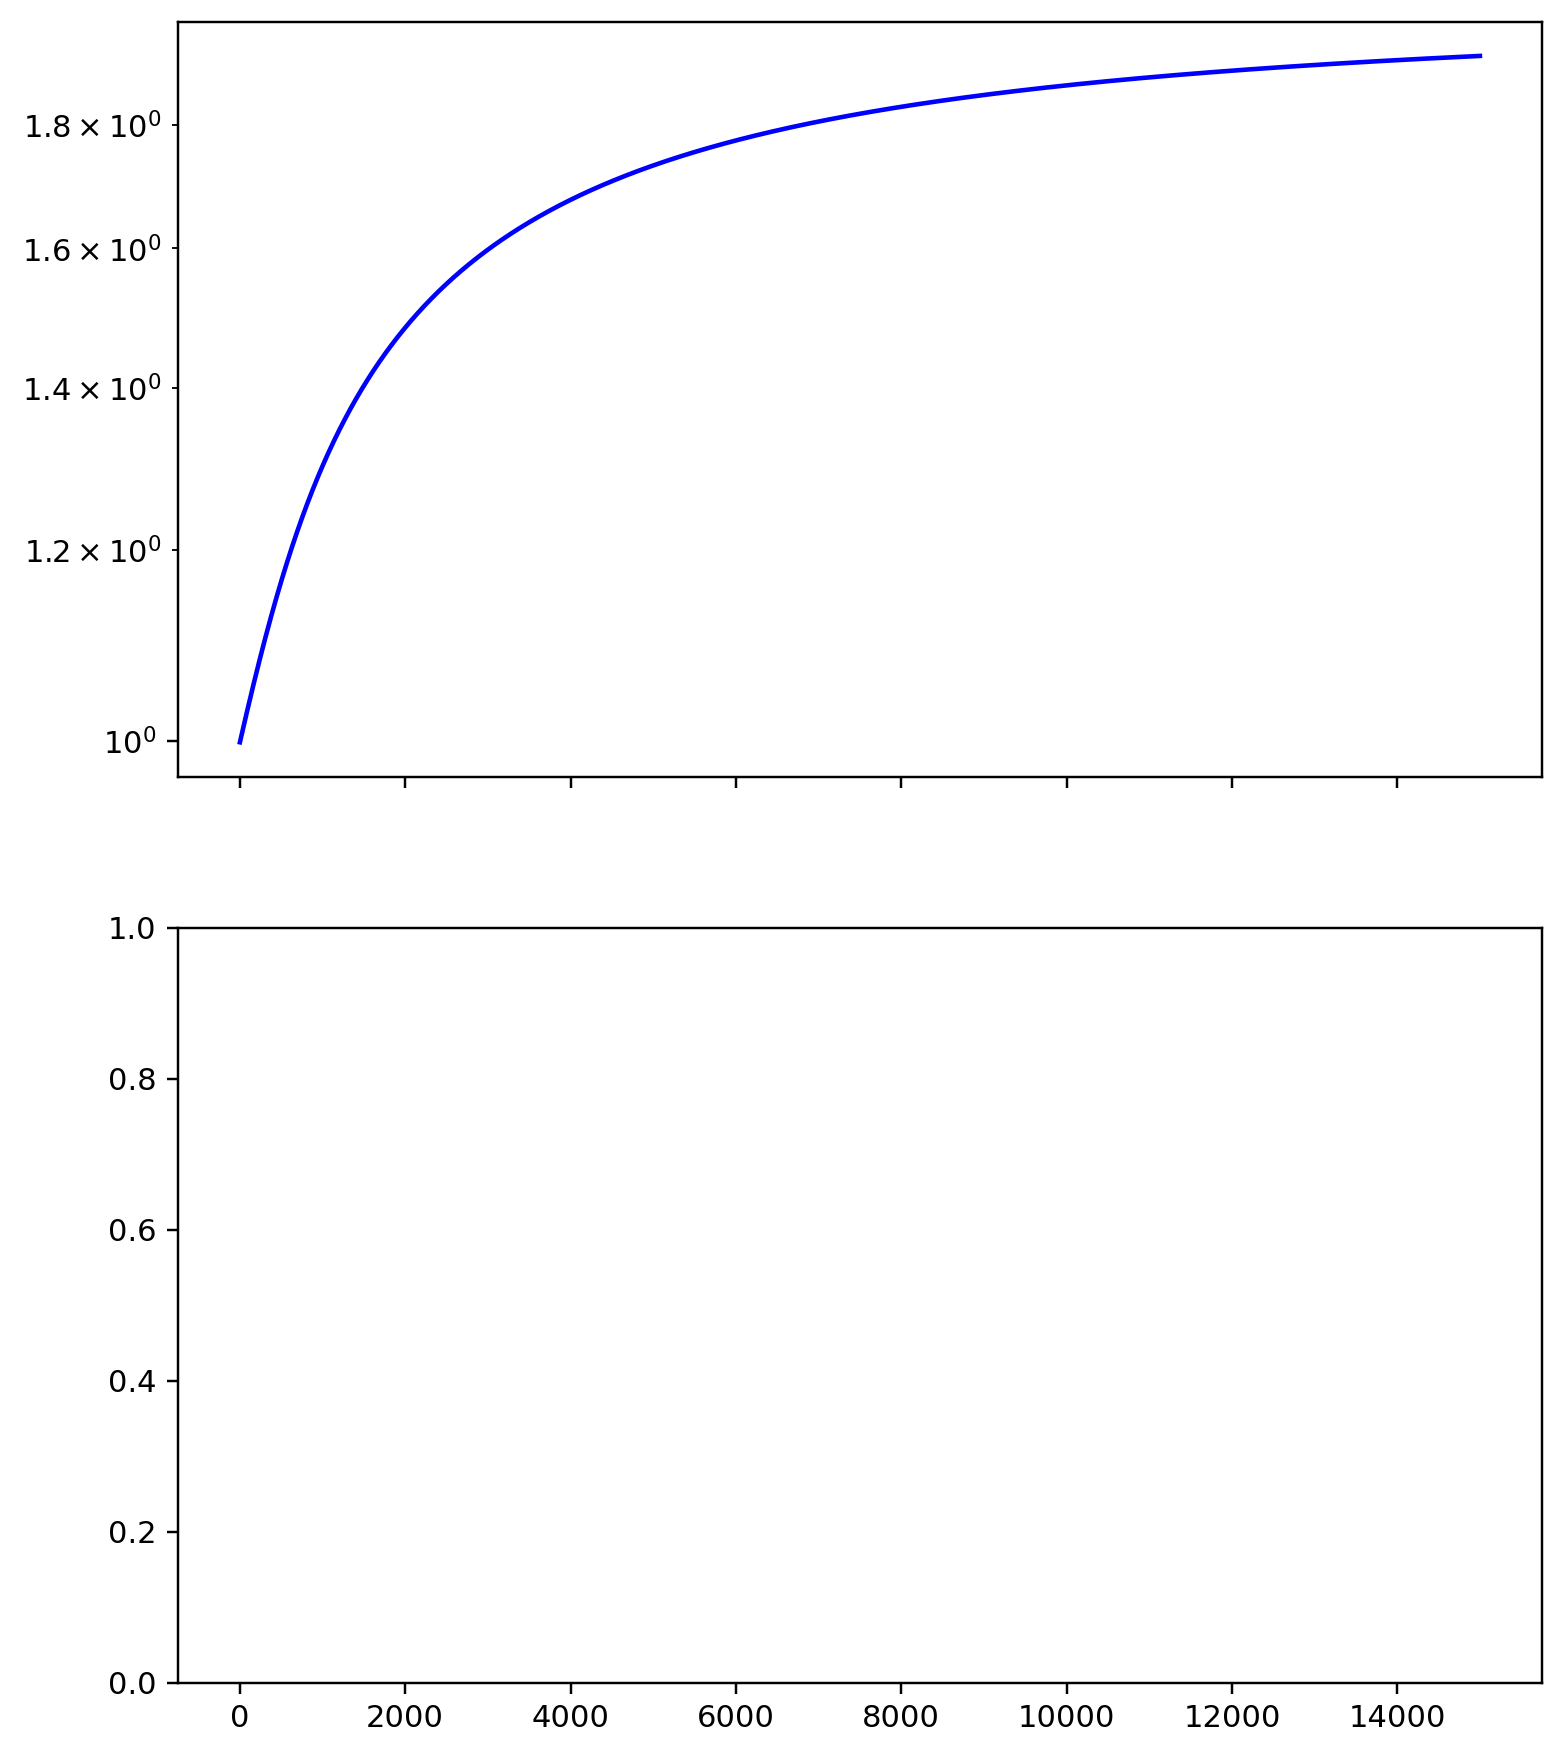

In [23]:
fig, axs = plt.subplots(2,sharex=True, figsize=(8, 10), dpi= 220)

axs[0].semilogy(np.abs((np.array(optlog['iterations']['fx'])+obj_true)/obj_true), 'b', label = 'f(x) for sk(GX^TM)')


axs[0].semilogy(optlog4['iterations']['distance'], 'b--', label = 'N(x) for sk(GX^TB)BX')
axs[0].axis(ymin=1e-7,ymax=1)
axs[0].legend()
plt.show()

In [31]:
x_tmp = x4
Bx = B@x_tmp
grad = -A@x_tmp
xtBx = x_tmp.T@Bx
def skew(x):
    return( 0.5*(x - x.T))

In [38]:
print(np.linalg.norm(skew(grad@x_tmp.T@B)))
print(np.linalg.norm(skew(grad @ Bx.T)@Bx))

0.003880625431518451
0.00026699971053663487


In [35]:
print(np.linalg.norm((np.eye(n) - Bx @ x_tmp.T)@grad))
print(np.linalg.norm(skew(x_tmp.T@grad)))
print(np.linalg.norm(xtBx-np.eye(p)))

0.5258166545086169
7.900767812170608e-14
1.9682516546996877e-09


In [34]:
x_sylv = scipy.linalg.solve_sylvester(a=-B,b=B,q=np.zeros((n,n)))

In [67]:
x_sylv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
np.linalg.norm(skew(-A@x_true@x_true.T@B)@Bx)

1.0292368534890048e-14

In [58]:
np.linalg.norm(skew(grad@(B**3@x_tmp).T))

3.7524857062557566

In [78]:
np.linalg.norm(skew(x_tmp.T @ grad))

3.327177531559659e-12

In [27]:
np.linalg.norm(Bx.T@ Bx - np.eye(p))

3.159319714555777

In [16]:
np.linalg.norm(.5*(grad@(Bx.T@Bx) - Bx@ (grad.T @ Bx)))

3.471228739674671e-05

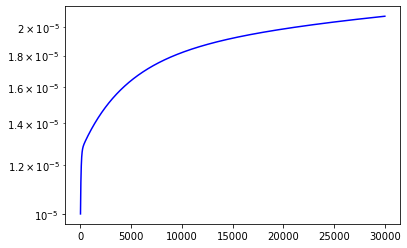

In [120]:
plt.semilogy(np.abs((np.array(optlog_final['iterations']['fx'])+obj_true)/obj_true), 'b', label = 'f(x) for sk(GX^TM)')


In [ ]:
fig, axs = plt.subplots(2,sharex=True, figsize=(8, 10), dpi= 220)

axs[0].semilogy(np.abs((np.array(optlog4['iterations']['fx'])+obj_true)/obj_true), 'b', label = 'f(x) for sk(GX^TM)')
axs[0].semilogy(np.abs((np.array(optlog_inv['iterations']['fx'])+obj_true)/obj_true), 'r', label = 'f(x) for sk(inv(M)GX^T)')


axs[0].semilogy(optlog4['iterations']['distance'], 'b--', label = 'N(x) for sk(GX^TM)')
axs[0].semilogy(optlog_inv['iterations']['distance'], 'r--', label = 'N(x) for sk(inv(M)GX^T)')
axs[0].axis(ymin=1e-7,ymax=1)
axs[0].legend()

#axs[1].plot(optlog4['iterations']['df1'], label = 'D[-Mgrad] f(x)')
#axs[1].plot(optlog4['iterations']['df2'], label = 'D[-grad] f(x)')
axs[1].semilogy(optlog4['iterations']['df3'], 'b', label = '<G,sk(GX^TM)> following sk(GX^TM)')
axs[1].semilogy(optlog_inv['iterations']['df2'], 'r', label = '<G,sk(inv(M)GX^T)> sk(inv(M)GX^T)')
axs[1].semilogy(optlog4['iterations']['df2'], 'r--', label = '<G,sk(inv(M)GX^T)> following sk(GX^TM)')
axs[1].semilogy(optlog_inv['iterations']['df3'], 'b--', label = '<G,sk(inv(M)GX^T)> following sk(inv(M)GX^T)')
axs[1].legend()

#axs[2].semilogy(optlog4['iterations']['dc1'], label = 'D[-Mgrad] N(x)')
#axs[2].semilogy(optlog4['iterations']['dc2'], label = 'D[-grad] N(x)')

#axs[2].legend()
plt.show()

In [50]:
Bx = B@x
grad = -A@x
xtBx = x.T@Bx
relative_gradient = grad @ xtBx - Bx @ grad.T @ x
normal_direction = x@(xtBx - np.eye(p))
objective_fun = lambda x: -np.trace(x.T@A @ x).item()
constraint_fun = lambda x: .25*np.linalg.norm(x.T@B@x - np.eye(p), 'fro')**2

In [46]:
t = 1e-10*relative_gradient
dc = (constraint_fun(x4 - t) - constraint_fun(x4)) / np.linalg.norm(t)
df = (objective_fun(x4 - t) - objective_fun(x4)) / np.linalg.norm(t)
print(dc)
print(df)

1.4710490665536754e+40
-10226434301488.004


In [48]:
constraint_fun(x4)

0.0005627768735760106

In [33]:
x4, optlog4 = solver.solve(A, B, p, 1/np.linalg.cond(B), 10, None, grad_type = 4, Binv = Binv, x0=x0)

Iteration 1, Objective: -21459.11 Distance: 3.01e-12
Iteration 2, Objective: -21459.15 Distance: 4.73e-03
Iteration 3, Objective: -21459.18 Distance: 9.41e-03
Iteration 4, Objective: -21459.22 Distance: 1.40e-02
Iteration 5, Objective: -21459.27 Distance: 1.86e-02
Iteration 6, Objective: -21459.31 Distance: 2.31e-02
Iteration 7, Objective: -21459.36 Distance: 2.76e-02
Iteration 8, Objective: -21459.41 Distance: 3.20e-02
Iteration 9, Objective: -21459.46 Distance: 3.64e-02
Iteration 10, Objective: -21459.52 Distance: 4.07e-02
Iteration 11, Objective: -21459.58 Distance: 4.50e-02
Iteration 12, Objective: -21459.64 Distance: 4.93e-02
Iteration 13, Objective: -21459.70 Distance: 5.35e-02
Iteration 14, Objective: -21459.76 Distance: 5.76e-02
Iteration 15, Objective: -21459.83 Distance: 6.17e-02
Iteration 16, Objective: -21459.90 Distance: 6.58e-02
Iteration 17, Objective: -21459.97 Distance: 6.98e-02
Iteration 18, Objective: -21460.05 Distance: 7.38e-02
Iteration 19, Objective: -21460.12 Di

In [28]:
x, optlog = solver.solve(A, B, p, 0.00000001, 100, None, grad_type = 3, Binv = Binv, x0=x0)

Iteration 1, Objective: -21522.07 Distance: 3.01e-12
Iteration 2, Objective: -21585.24 Distance: 3.14e-07
Iteration 3, Objective: -21648.58 Distance: 6.29e-07
Iteration 4, Objective: -21712.09 Distance: 9.45e-07
Iteration 5, Objective: -21775.77 Distance: 1.26e-06
Iteration 6, Objective: -21839.62 Distance: 1.58e-06
Iteration 7, Objective: -21903.65 Distance: 1.90e-06
Iteration 8, Objective: -21967.84 Distance: 2.22e-06
Iteration 9, Objective: -22032.22 Distance: 2.54e-06
Iteration 10, Objective: -22096.76 Distance: 2.86e-06
Iteration 11, Objective: -22161.48 Distance: 3.18e-06
Iteration 12, Objective: -22226.38 Distance: 3.50e-06
Iteration 13, Objective: -22291.45 Distance: 3.83e-06
Iteration 14, Objective: -22356.69 Distance: 4.15e-06
Iteration 15, Objective: -22422.11 Distance: 4.48e-06
Iteration 16, Objective: -22487.70 Distance: 4.80e-06
Iteration 17, Objective: -22553.48 Distance: 5.13e-06
Iteration 18, Objective: -22619.42 Distance: 5.46e-06
Iteration 19, Objective: -22685.54 Di

In [12]:
solver = GeneralizedLanding(maxiter = 30000, mingradnorm=1e-6)
x5, optlog5 = solver.solve(A, B, p, 0.0005, 10, None, grad_type = 5, Binv = Binv, x0=x0)

Iteration 1, Objective: -21461.88 Distance: 3.01e-12
Iteration 2, Objective: -21464.68 Distance: 1.75e-05
Iteration 3, Objective: -21467.48 Distance: 3.50e-05
Iteration 4, Objective: -21470.28 Distance: 5.25e-05
Iteration 5, Objective: -21473.08 Distance: 7.01e-05
Iteration 6, Objective: -21475.88 Distance: 8.77e-05
Iteration 7, Objective: -21478.68 Distance: 1.05e-04
Iteration 8, Objective: -21481.49 Distance: 1.23e-04
Iteration 9, Objective: -21484.29 Distance: 1.40e-04
Iteration 10, Objective: -21487.09 Distance: 1.58e-04
Iteration 11, Objective: -21489.90 Distance: 1.76e-04
Iteration 12, Objective: -21492.70 Distance: 1.93e-04
Iteration 13, Objective: -21495.51 Distance: 2.11e-04
Iteration 14, Objective: -21498.31 Distance: 2.29e-04
Iteration 15, Objective: -21501.12 Distance: 2.46e-04
Iteration 16, Objective: -21503.92 Distance: 2.64e-04
Iteration 17, Objective: -21506.73 Distance: 2.82e-04
Iteration 18, Objective: -21509.54 Distance: 3.00e-04
Iteration 19, Objective: -21512.34 Di

KeyboardInterrupt: 

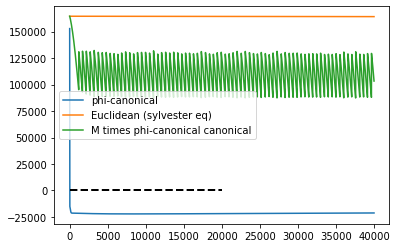

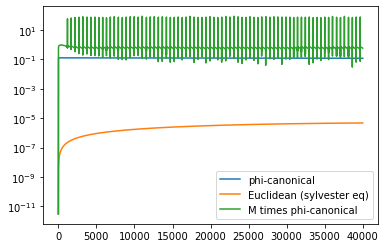

In [37]:
plt.plot(optlog['iterations']['fx'] + obj_true, label='phi-canonical')
plt.plot(optlog5['iterations']['fx'] + obj_true, label='Euclidean (sylvester eq)')
plt.plot(optlog4['iterations']['fx'] + obj_true, label='M times phi-canonical canonical')
plt.plot([0, 20000], [0, 0], 'k--', lw=2)
#plt.ylim([-4500, 10000])
plt.legend()
plt.show()
plt.semilogy(optlog['iterations']['distance'][:], label='phi-canonical')
plt.semilogy(optlog5['iterations']['distance'][:], label='Euclidean (sylvester eq)')
plt.semilogy(optlog4['iterations']['distance'][:], label='M times phi-canonical')
#plt.ylim([1e-6, 1])
plt.legend()
plt.show()

In [53]:
optlog['iterations']['distance']

[0.00038511212700346624,
 0.00038511174531246007,
 0.00038511136425889935,
 0.0003851109830464365,
 0.00038511060179599653,
 0.0003851102205431692,
 0.0003851098395197982,
 0.0003851094581167374,
 0.00038510907661585,
 0.00038510869600545666,
 0.00038510831407516036,
 0.00038510793328957516,
 0.00038510755208666223,
 0.00038510717050702363,
 0.00038510678936817344,
 0.0003851064086229335,
 0.0003851060270975016,
 0.00038510564626910166,
 0.0003851052648059584,
 0.00038510488396039326,
 0.00038510450283365,
 0.0003851041218683404,
 0.00038510374034019933,
 0.00038510335925331907,
 0.00038510297806315565,
 0.000385102597030375,
 0.0003851022165679676,
 0.0003851018350438652,
 0.00038510145378296736,
 0.0003851010727915994,
 0.0003851006922274253,
 0.00038510031098781307,
 0.00038509992987994406,
 0.00038509954876691604,
 0.0003850991680350307,
 0.0003850987864770153,
 0.0003850984062152335,
 0.0003850980251991147,
 0.00038509764376829235,
 0.0003850972633127945,
 0.0003850968818554766,
 

In [91]:
H = np.random.randn(n,n)
H = H / np.linalg.norm(H)
np.linalg.norm(H)**2 - np.inner(H.flatten(),H.T.flatten())

0.9731535511976732

In [110]:
g = -A@x4
x = x4
H = g@x.T

In [111]:
np.inner(H.flatten(),H.flatten()) - np.inner(H.flatten(),H.T.flatten())

148886972.99954325

In [112]:
np.inner((B@H).flatten(),H.flatten()) - np.inner((B@H).flatten(),H.T.flatten())

11796911.502425017

In [107]:
np.inner(H.flatten(),H.flatten()) 

285529615.199893